In [1]:
#%%

import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from pykalman import KalmanFilter
import warnings
from scipy.optimize import minimize
import backtrader as bt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout




warnings.filterwarnings('ignore')

In [2]:
#%%

# ===========================
# Data Preparation Functions
# ===========================

def prepare_data(symbols, start_date, end_date):
    df = yf.download(symbols, start=start_date, end=end_date)
    price_df = df['Adj Close']
    price_df.dropna(axis=1, inplace=True)
    return price_df

def split_data(price_df, split_ratio=0.8):
    split = int(price_df.shape[0] * split_ratio)
    training_data = price_df[:split]
    testing_data = price_df[split:]
    testing_data_with_window = price_df[split - 60:]  # Include window for rolling calculations
    return training_data, testing_data, testing_data_with_window

def prepare_data_for_backtrader(price_df):
    data_dict = {}
    for ticker in price_df.columns:
        df_ticker = pd.DataFrame({
            'open': price_df[ticker],
            'high': price_df[ticker],
            'low': price_df[ticker],
            'close': price_df[ticker],
            'volume': 1000000  # Dummy volume since volume data may not be available
        }, index=price_df.index)
        data_dict[ticker] = df_ticker
    return data_dict

In [3]:
#%%

# =================================
# Kalman Filter Regression Function
# =================================

def KalmanFilterRegression(x,y):
    model1 = sm.OLS(y,x)
    result = model1.fit()
    obs_mat = np.vstack([x]).T[:, np.newaxis] 

    kf = KalmanFilter(
        initial_state_mean = result.params,
        initial_state_covariance = result.cov_params(),
        transition_matrices = 1,
        transition_offsets = 0,
        observation_matrices = obs_mat,
        observation_offsets = 0,
        observation_covariance = result.mse_model,
        n_dim_obs = 1,
        n_dim_state = 1
    )
    kf = kf.em(y, em_vars = ["transition_covariance"])
    state_means, state_covs = kf.filter(y)
    return state_means.flatten()

In [4]:
#%%

# ==========================
# Spread Return Calculation Function
# ==========================

def calculate_return_matrix(price_df, coint_pair):
    num_days = price_df.shape[0]
    num_pairs = len(coint_pair)
    return_matrix = np.zeros((num_days, num_pairs))

    for j in range(num_pairs):
        x = price_df.loc[:, coint_pair[j][0]].values
        y = price_df.loc[:, coint_pair[j][1]].values
        hedgeratio = KalmanFilterRegression(x, y)
        returns = np.diff(y - hedgeratio * x) / (y - hedgeratio * x)[:-1]
        return_matrix[1:, j] = returns
    
    return return_matrix[1:]  # Remove first row (contains zeros due to diff)

In [ ]:
#%%

# =====================
# Weight Calculation Classes
# =====================

class RiskParity:
    def __init__(self, cov_matrix, initial_weights):
        self.cov_matrix = cov_matrix
        self.initial_weights = initial_weights
    
    def RP_objective(self, weights):
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        marginal_contrib = np.dot(self.cov_matrix, weights) / portfolio_std
        risk_contrib = weights * marginal_contrib
        target = portfolio_std / len(weights)
        risk_diffs = risk_contrib - target
        return np.sum(risk_diffs ** 2)
    
    def get_weights(self):
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        bounds = [(0, 1)] * len(self.initial_weights)
        result = minimize(
            self.RP_objective, self.initial_weights, method='SLSQP',
            bounds=bounds, constraints=constraints
        )
        return result.x

class MaxSharpeRatio:
    def __init__(self, avg_returns, cov_matrix, initial_weights, risk_free_rate=0):
        self.avg_returns = avg_returns
        self.cov_matrix = cov_matrix
        self.initial_weights = initial_weights
        self.risk_free_rate = risk_free_rate

    def negative_sharpe_ratio(self, weights):
        portfolio_return = np.dot(weights, self.avg_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        if portfolio_volatility == 0:
            return np.inf  # Avoid division by zero
        sharpe_ratio = (portfolio_return - self.risk_free_rate) / portfolio_volatility
        return -sharpe_ratio  # Negative because we minimize

    def get_weights(self):
        constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
        bounds = [(0, 1)] * len(self.initial_weights)
        result = minimize(
            self.negative_sharpe_ratio, self.initial_weights, method='SLSQP',
            bounds=bounds, constraints=constraints
        )
        return result.x

class RRLModel:
    def __init__(self, return_matrix, num_pairs, window_size=60, learning_rate=10):
        self.set_seed(0)   # set seed for initializing theta
        self.return_matrix = return_matrix  
        self.num_pairs = num_pairs 
        self.window_size = window_size  
        self.learning_rate = learning_rate  

        self.theta = np.random.randn(num_pairs, window_size + 2) * 0.1  # +2 for bias and Ft-1
        self.F_prev = np.ones(num_pairs) / num_pairs

        self.portfolio_returns = []  
        self.F_history = []
        self.x_history = []

        self.backprop_steps = 60  
    
    
    def set_seed(self, seed):
        np.random.seed(seed)

    def forward_pass(self, t):
        x_t = np.zeros((self.num_pairs, self.window_size + 2))  # +2 for bias and Ft-1  
        for j in range(self.num_pairs):
            x_t[j, 0] = 1  # Bias term 
            x_t[j, 1:self.window_size + 1] = self.return_matrix[t - self.window_size:t, j][::-1]  # Lookback window
            x_t[j, -1] = self.F_prev[j]  # Ft-1 

        z = np.zeros(self.num_pairs)  
        for p in range(self.num_pairs):
            z[p] = np.dot(self.theta[p], x_t[p])
        z = z - np.max(z) 
        F = np.exp(z) / np.sum(np.exp(z))

        self.x_t = x_t
        self.F_prev = F  
        self.F_history.append(F)
        self.x_history.append(x_t)
        if len(self.F_history) > self.backprop_steps + 1:
            self.F_history.pop(0)
            self.x_history.pop(0)
        return F

    def backpropagation(self, t):
        max_iterations = 10000  
        tol = 0.00001  
        gradient_norm = 0  
        for iteration in range(max_iterations):
            F = self.forward_pass(t)
            portfolio_r = np.dot(F, self.return_matrix[t][:])
            R_window = np.array(self.portfolio_returns + [portfolio_r])
            A_n = np.mean(R_window)
            B_n = np.mean(R_window ** 2)
            n = len(R_window)
            if n < 2:                
                continue    
            K_n = np.sqrt(n / (n - 1))
            denominator = K_n * (B_n - A_n ** 2 + 1e-6) ** 1.5
            if denominator == 0:
                continue    
            C = (B_n - A_n * portfolio_r) / denominator * (1 / n)
            gradient_norm = 0
            for p in range(self.num_pairs):
                dz_dtheta = np.zeros_like(self.theta[p])  
                dF_prev_dtheta = 0
                # Truncated Backpropagation Through Time (BPTT)
                for step in reversed(range(len(self.F_history))):
                    F_t_step = self.F_history[step]
                    x_t_step = self.x_history[step][p]
                    dz_dtheta = x_t_step + self.theta[p][-1] * dF_prev_dtheta
                    F_p = F_t_step[p]
                    dF_prev_dtheta = F_p * (1 - F_p) * dz_dtheta
                dR_dtheta = np.zeros_like(self.theta[p])

                for k in range(self.num_pairs):
                    r_t_k = self.return_matrix[t, k]
                    F_k = F[k]
                    if k == p:
                        dF_t_k_dz_t_p = F_k * (1 - F_k)             # For i = j
                    else:
                        dF_t_k_dz_t_p = -F_k * F[p]                 # For i != j
                    dR_dtheta += r_t_k * dF_t_k_dz_t_p * dz_dtheta
                gradient = C * dR_dtheta
                self.theta[p] += self.learning_rate * gradient
                gradient_norm += np.linalg.norm(gradient)

            if gradient_norm < tol:
                print(f"Gradient ascent converged after {iteration + 1} iterations., Gradient Norm: {gradient_norm}")
                break
        else:
            print(f"Reached maximum iterations ({max_iterations}) without full convergence., Gradient Norm: {gradient_norm}")
        self.portfolio_returns.append(portfolio_r)  

    def update_parameters(self, t):
        self.backpropagation(t)
        F = self.F_prev
        return F

    def get_dynamic_weights(self):
        time_length = self.return_matrix.shape[0]
        dynamic_weights = np.zeros((time_length, self.num_pairs))
        for t in range(self.window_size, time_length):
            F_t = self.update_parameters(t)
            dynamic_weights[t] = F_t  
        return dynamic_weights

class LSTMModel:
    def __init__(self, return_matrix, num_pairs, window_size=60, learning_rate=0.0001):
        self.set_seed(0)
        self.return_matrix = return_matrix
        self.num_pairs = num_pairs
        self.window_size = window_size
        self.learning_rate = learning_rate  

        self.X_train, self.y_train = self.create_lstm_dataset(self.return_matrix, self.window_size)
        self.model = self.build_model(input_shape=(self.window_size, self.num_pairs))
    
    def set_seed(self, seed):
        np.random.seed(seed)

    def create_lstm_dataset(self, return_matrix, window_size):
        X = []
        y = []
        for i in range(window_size, len(return_matrix)):
            X.append(return_matrix[i - window_size:i])  
            y.append(return_matrix[i]) 
        return np.array(X), np.array(y)
        
    def sharpe_ratio_loss(self, y_true, y_pred):
        portfolio_returns = tf.reduce_mean(y_pred * y_pred, axis=1) 
        mean_return = tf.reduce_mean(portfolio_returns)
        std_return = tf.math.reduce_std(portfolio_returns) * 100   # scale up
        sharpe_ratio = (mean_return - 0.0) / (std_return + 1e-6)
        return -sharpe_ratio
        
    def build_model(self, input_shape):
        model = Sequential()
        model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(units=128, return_sequences=False, input_shape=input_shape))
        model.add(Dropout(rate=0.3))
        model.add(Dense(self.num_pairs, activation='relu')) # relu: max(0, x) 

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss=self.sharpe_ratio_loss)
        return model
        
    def train_model(self, epochs=300, batch_size=64):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.model.fit(self.X_train, self.y_train, 
                       epochs=epochs, 
                       batch_size=batch_size,
                       callbacks=[early_stopping],  
                       verbose=1)
        
    def get_dynamic_weights(self):
        dynamic_weights = []
        for t in range(self.window_size, len(self.return_matrix)):
            X_input = self.return_matrix[t - self.window_size:t].reshape(1, self.window_size, self.num_pairs)
            weights = self.model.predict(X_input)
            weights = weights / np.sum(weights)  
            dynamic_weights.append(weights.flatten())
            
        # Zero-pad the initial window
        zero_padding = np.zeros((self.window_size, self.num_pairs))
        dynamic_weights = np.vstack((zero_padding, dynamic_weights))
        return dynamic_weights

In [ ]:
#%%

# =====================
# Backtrader Strategy
# =====================

class PairTradingStrategy(bt.Strategy):
    params = (
        ('pairs', None),
        ('best_z_scores', None),
        ('hedge_ratios', None),
        ('weights', None),
        ('dynamic_weights', None),
    )

    def __init__(self):
        self.pairs = self.params.pairs
        self.best_z_scores = self.params.best_z_scores
        self.hedge_ratios = self.params.hedge_ratios
        self.dynamic_weights = self.params.dynamic_weights

        self.spreads = {}
        self.zscores = {}
        self.dataclose = {}
        self.positions_pair = {}
        self.portfolio_values = []
        self.cash_values = []
        self.dates = []
        self.drawdowns = []

        for d in self.datas:
            self.dataclose[d._name] = d.close

        for i, pair in enumerate(self.pairs):
            pair_tuple = tuple(pair)
            asset1 = pair_tuple[0]
            asset2 = pair_tuple[1]

            hedge_ratio = float(self.hedge_ratios[i]) 

            spread = self.dataclose[asset1] - hedge_ratio * self.dataclose[asset2]
            spread_mean = bt.indicators.MovingAverageSimple(spread, period=60)
            spread_std = bt.indicators.StandardDeviation(spread, period=60)
            zscore = (spread - spread_mean) / spread_std

            self.spreads[pair_tuple] = spread
            self.zscores[pair_tuple] = zscore
            self.positions_pair[pair_tuple] = 0  

    def next(self):
        t = len(self) - 1  

        for i, pair in enumerate(self.pairs):
            pair_tuple = tuple(pair)
            asset1, asset2 = pair_tuple
            zscore = self.zscores[pair_tuple][0]
            long_entry, long_exit, short_entry, short_exit = self.best_z_scores[i]

            if self.dynamic_weights is not None:
                weights_length = self.dynamic_weights.shape[0]
                if t >= weights_length:
                    weight = self.dynamic_weights[-1, i]
                else:
                    weight = self.dynamic_weights[t, i]
            elif self.params.weights is not None:
                weight = self.params.weights[i]
            else:
                weight = 1.0 / len(self.pairs)

            value = self.broker.get_value()
            size_asset1 = int((value * weight) / self.dataclose[asset1][0])
            size_asset2 = int((value * weight) / self.dataclose[asset2][0])

            if self.positions_pair[pair_tuple] == 0:
                if zscore < long_entry:
                    self.buy(data=self.getdatabyname(asset1), size=size_asset1)
                    self.sell(data=self.getdatabyname(asset2), size=size_asset2)
                    self.positions_pair[pair_tuple] = 1
                elif zscore > short_entry:
                    self.sell(data=self.getdatabyname(asset1), size=size_asset1)
                    self.buy(data=self.getdatabyname(asset2), size=size_asset2)
                    self.positions_pair[pair_tuple] = -1
            elif self.positions_pair[pair_tuple] == 1:
                if zscore > long_exit:
                    self.close(self.getdatabyname(asset1))
                    self.close(self.getdatabyname(asset2))
                    self.positions_pair[pair_tuple] = 0
            elif self.positions_pair[pair_tuple] == -1:
                if zscore < short_exit:
                    self.close(self.getdatabyname(asset1))
                    self.close(self.getdatabyname(asset2))
                    self.positions_pair[pair_tuple] = 0
        
        self.portfolio_values.append(self.broker.get_value())
        self.cash_values.append(self.broker.get_cash())
        self.dates.append(self.datas[0].datetime.date(0))
        drawdown = self.analyzers.drawdown.get_analysis()['drawdown']
        self.drawdowns.append(drawdown)

In [7]:
#%%

# =====================
# Backtesting Function
# =====================

def run_backtest(data_dict, used_tickers, coint_pair, best_z_scores_list, hedge_ratios, weights=None, dynamic_weights=None):
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(1000000)
    cerebro.broker.setcommission(commission=0.0001)

    for ticker in used_tickers:
        data = bt.feeds.PandasData(dataname=data_dict[ticker], name=ticker)
        cerebro.adddata(data)

    cerebro.addstrategy(
        PairTradingStrategy,
        pairs=coint_pair,
        best_z_scores=best_z_scores_list,
        hedge_ratios=hedge_ratios,
        weights=weights,
        dynamic_weights=dynamic_weights
    )

    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio', timeframe=bt.TimeFrame.Days, annualize=True)
    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addobserver(bt.observers.DrawDown)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    results = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    sharpe_ratio = results[0].analyzers.sharpe_ratio.get_analysis()
    print(f"Sharpe Ratio: {sharpe_ratio['sharperatio']:.2f}")
    
    annual_return = results[0].analyzers.annual_return.get_analysis()
    total_return = 1
    for year, ret in annual_return.items():
        total_return *= (1 + ret)
    num_years = len(annual_return) - 1
    cagr = (total_return) ** (1 / num_years) - 1
    print(f"Compound Annual Growth Rate (CAGR): {cagr * 100:.2f}%")

    strategy = results[0]
    dates = strategy.dates
    portfolio_values = np.array(strategy.portfolio_values)
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    var_95 = np.percentile(returns, 5) 
    var_99 = np.percentile(returns, 1)  
    print(f"VaR 95%: {var_95 * 100:.2f}%")
    print(f"VaR 99%: {var_99 * 100:.2f}%")
    daily_volatility = np.std(returns)
    annualized_volatility = daily_volatility * np.sqrt(252) 
    print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")


    cash_values = strategy.cash_values
    drawdown_values = strategy.drawdowns

    strategy = results[0]
    dates = strategy.dates
    portfolio_values = strategy.portfolio_values
    cash_values = strategy.cash_values
    drawdown_values = strategy.drawdowns

    # Plot Portfolio Value, Cash Value, and Drawdown over time
    plt.figure(figsize=(12, 8))

    # Plot Portfolio Value and Cash
    plt.subplot(2, 1, 1)
    plt.plot(dates, portfolio_values, label='Portfolio Value', color='blue')
    plt.plot(dates, cash_values, label='Cash Value', color='orange')
    plt.title('Portfolio Value and Cash Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    # Plot Drawdown
    plt.subplot(2, 1, 2)
    plt.plot(dates, drawdown_values, label='Drawdown', color='red')
    plt.title('Drawdown Over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [8]:
#%%

# =====================
# Main Execution
# =====================

# Define symbols and fetch data
symbols = ['KXI', 'GOOGL', 'UPRO', 'ORCL', 'VDC', 'CMCSA']
price_df = prepare_data(symbols, start_date='2013-01-01', end_date='2023-12-31')

# Split data
price_df_training, price_df_testing, price_df_testing_60_window = split_data(price_df)

# Prepare data for backtrader
data_dict_training = prepare_data_for_backtrader(price_df_training)
data_dict_testing = prepare_data_for_backtrader(price_df_testing)
data_dict_testing_60_window = prepare_data_for_backtrader(price_df_testing_60_window)

# Define cointegrated pairs and best z-scores
coint_pair = [['KXI', 'CMCSA'], 
              ['ORCL', 'GOOGL'], 
              ['UPRO', 'ORCL'], 
              ['VDC', 'CMCSA']]

best_z_score = [
    {'long_entry_Zscore': -2.4, 'long_exit_Zscore': -0.4, 'short_entry_Zscore': 0.4, 'short_exit_Zscore': 0.2},
    {'long_entry_Zscore': -2.4, 'long_exit_Zscore': -0.0, 'short_entry_Zscore': 1.4, 'short_exit_Zscore': 1.2},
    {'long_entry_Zscore': -2.4, 'long_exit_Zscore': -1.0, 'short_entry_Zscore': 0.6, 'short_exit_Zscore': 0.4},
    {'long_entry_Zscore': -2.2, 'long_exit_Zscore': -0.2, 'short_entry_Zscore': 0.2, 'short_exit_Zscore': 0.0}
]

best_z_scores_list = [
    (
        params['long_entry_Zscore'],
        params['long_exit_Zscore'],
        params['short_entry_Zscore'],
        params['short_exit_Zscore']
    )
    for params in best_z_score
]

# Calculate hedge ratios
hedge_ratios = []
for j in range(len(coint_pair)):
    x = price_df_training.loc[:, coint_pair[j][0]].values
    y = price_df_training.loc[:, coint_pair[j][1]].values
    hedgeratio = KalmanFilterRegression(x, y)
    hedge_ratios.append(float(hedgeratio[-1]))

# Prepare list of used tickers
used_tickers = set()
for pair in coint_pair:
    used_tickers.update(pair)
used_tickers = list(used_tickers)



[*********************100%***********************]  6 of 6 completed


Starting Portfolio Value: 1000000.00
Final Portfolio Value: 1487273.53
Sharpe Ratio: 1.45
Compound Annual Growth Rate (CAGR): 21.95%
VaR 95%: -1.01%
VaR 99%: -1.98%
Annualized Volatility: 13.01%


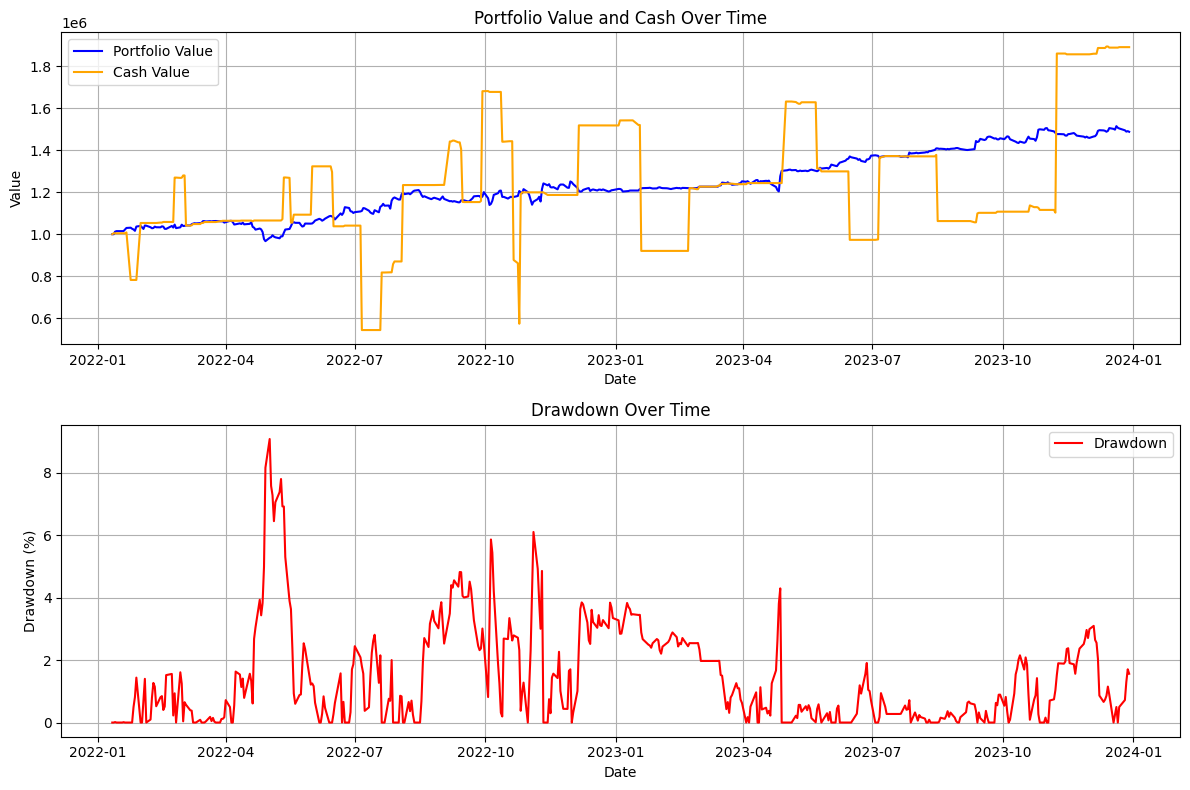

In [9]:
#%%

# Run Equal Weighting Backtest
equal_weight = [1.0 / len(coint_pair)] * len(coint_pair)
data_dict = data_dict_testing
run_backtest(
    data_dict=data_dict,
    used_tickers=used_tickers,
    coint_pair=coint_pair,
    best_z_scores_list=best_z_scores_list,
    hedge_ratios=hedge_ratios,
    weights=equal_weight
)

Starting Portfolio Value: 1000000.00
Final Portfolio Value: 1395247.07
Sharpe Ratio: 1.27
Compound Annual Growth Rate (CAGR): 18.12%
VaR 95%: -0.97%
VaR 99%: -2.14%
Annualized Volatility: 12.39%


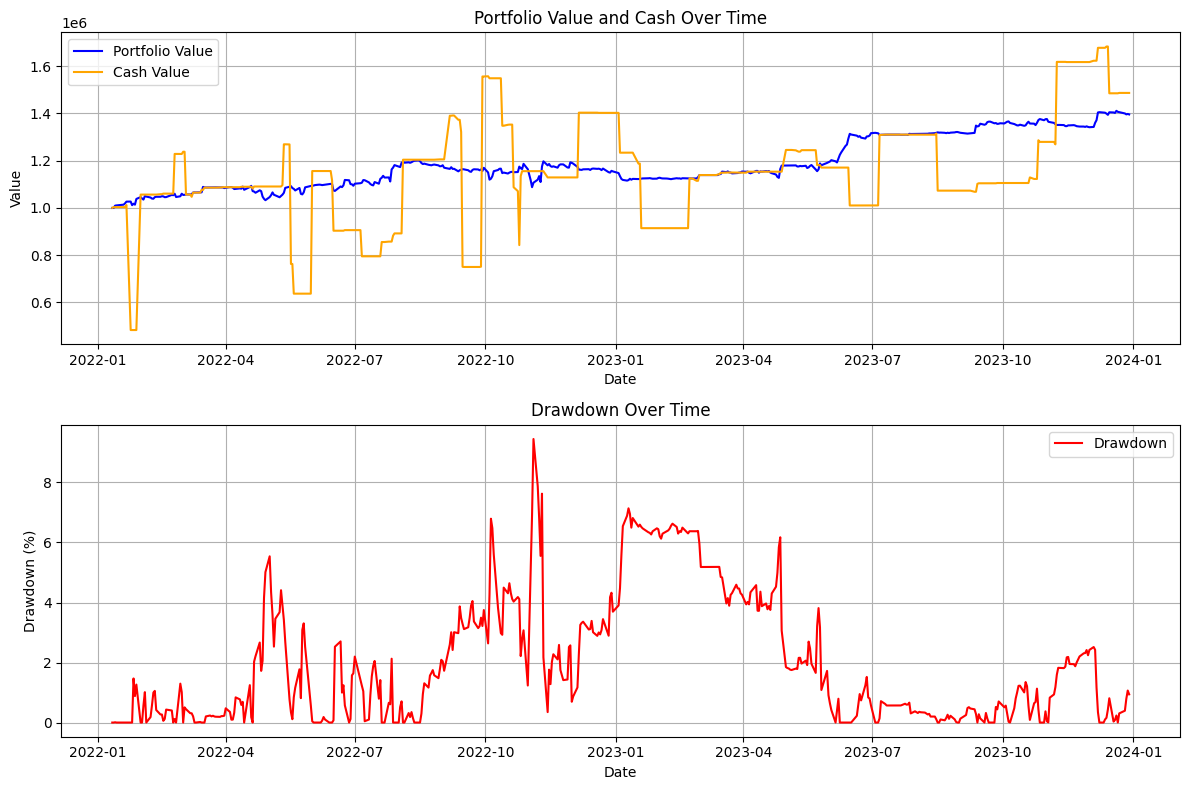

In [10]:
#%%

# Run Risk Parity Backtest
scale_factor = 100
return_matrix_training = calculate_return_matrix(price_df_training, coint_pair)
cov_matrix = np.cov(return_matrix_training.T)  
initial_weights = np.array([1 / len(coint_pair)] * len(coint_pair))
risk_parity = RiskParity(cov_matrix*scale_factor, initial_weights) # Annualized covariance & scale up
risk_parity_weights = risk_parity.get_weights()
run_backtest(
    data_dict=data_dict,
    used_tickers=used_tickers,
    coint_pair=coint_pair,
    best_z_scores_list=best_z_scores_list,
    hedge_ratios=hedge_ratios,
    weights=risk_parity_weights
)

Starting Portfolio Value: 1000000.00
Final Portfolio Value: 1341963.50
Sharpe Ratio: 0.83
Compound Annual Growth Rate (CAGR): 15.84%
VaR 95%: -1.42%
VaR 99%: -2.47%
Annualized Volatility: 17.63%


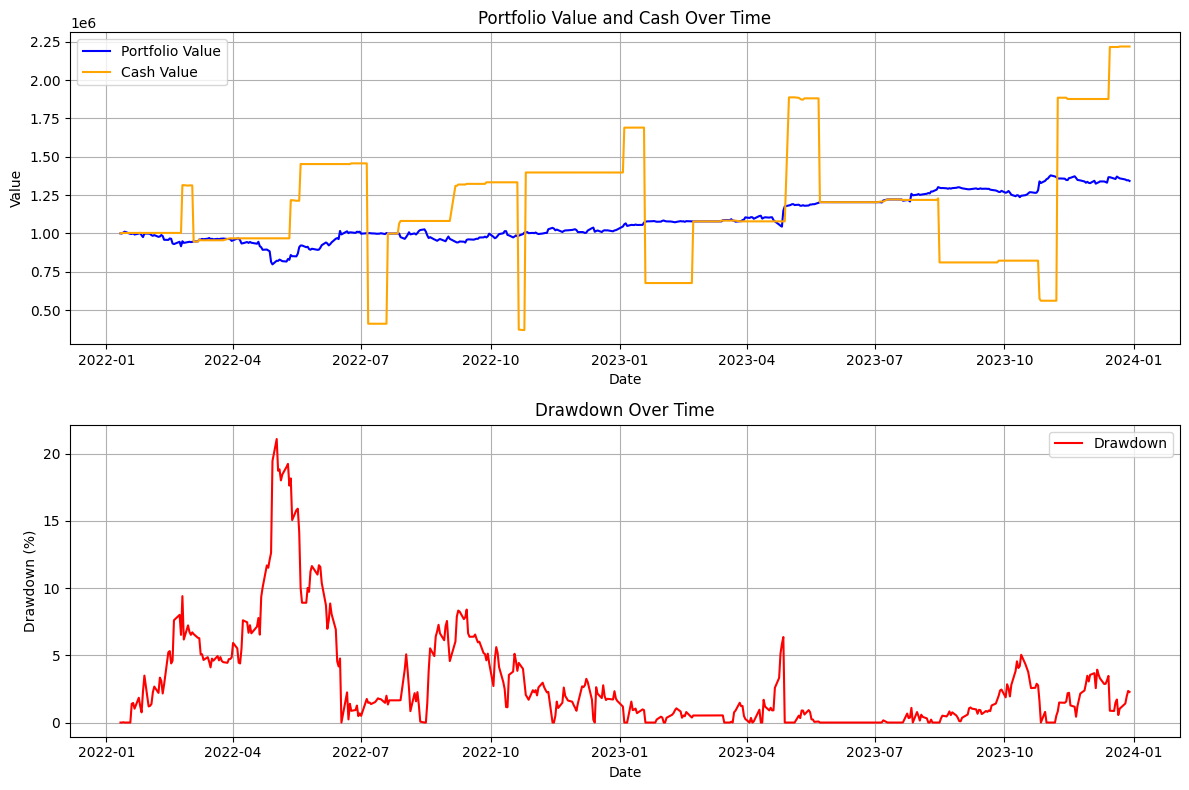

In [11]:
#%%

# Run Maximum Sharpe Ratio Backtest
scale_factor = 100
avg_returns = np.mean(return_matrix_training, axis=0) 
msr = MaxSharpeRatio(avg_returns, cov_matrix*scale_factor, initial_weights) # Annualized covariance & scale up
msr_weights = msr.get_weights()
run_backtest(
    data_dict=data_dict,
    used_tickers=used_tickers,
    coint_pair=coint_pair,
    best_z_scores_list=best_z_scores_list,
    hedge_ratios=hedge_ratios,
    weights=msr_weights
)

Reached maximum iterations (10000) without full convergence., Gradient Norm: 0
Gradient ascent converged after 118 iterations., Gradient Norm: 2.7785519582460015e-15
Gradient ascent converged after 1 iterations., Gradient Norm: 3.742772217981048e-13
Gradient ascent converged after 370 iterations., Gradient Norm: 9.974860578954132e-06
Gradient ascent converged after 373 iterations., Gradient Norm: 9.984343396630977e-06
Gradient ascent converged after 372 iterations., Gradient Norm: 9.978421808317216e-06
Gradient ascent converged after 1 iterations., Gradient Norm: 1.8092938399969013e-07
Gradient ascent converged after 1 iterations., Gradient Norm: 3.34396741872891e-07
Gradient ascent converged after 375 iterations., Gradient Norm: 9.997212633943065e-06
Gradient ascent converged after 1570 iterations., Gradient Norm: 9.998487923718854e-06
Gradient ascent converged after 62 iterations., Gradient Norm: 1.0986557012982961e-07
Gradient ascent converged after 391 iterations., Gradient Norm: 9

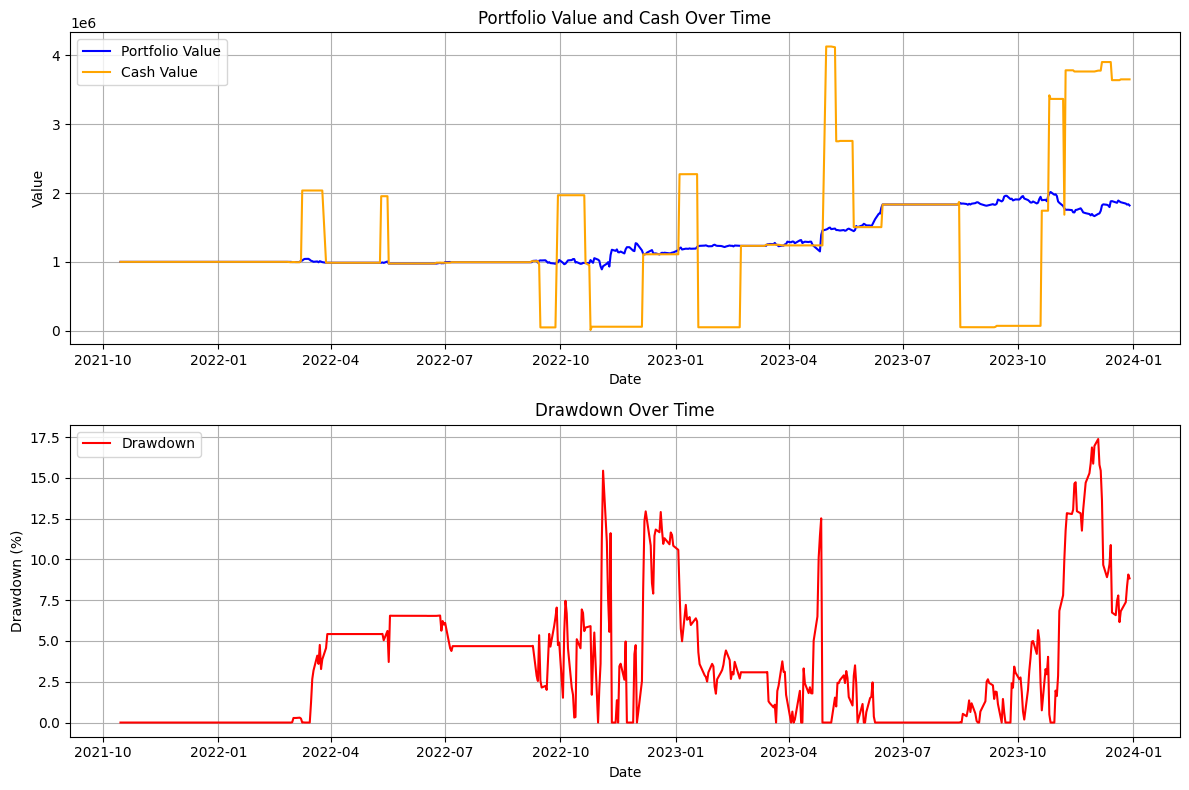

In [12]:
#%%

# Run RRL Backtest
return_matrix_testing_60_window = calculate_return_matrix(price_df_testing_60_window, coint_pair)
rrl_model = RRLModel(return_matrix_testing_60_window, len(coint_pair))
dynamic_weights_rrl = rrl_model.get_dynamic_weights()
data_dict = data_dict_testing_60_window
run_backtest(
    data_dict=data_dict,
    used_tickers=used_tickers,
    coint_pair=coint_pair,
    best_z_scores_list=best_z_scores_list,
    hedge_ratios=hedge_ratios,
    dynamic_weights=dynamic_weights_rrl
)

Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: -0.0064
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: -0.0090
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: -0.0119
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: -0.0138
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: -0.0171
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: -0.0195
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: -0.0233
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: -0.0301
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: -0.0392
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: -0.0473
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: -0.0490
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: -0.0579
Epoch 13/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: -0.0578
Epoch 14/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: -0.0613
Epoch 15/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: -0.0642
Ep

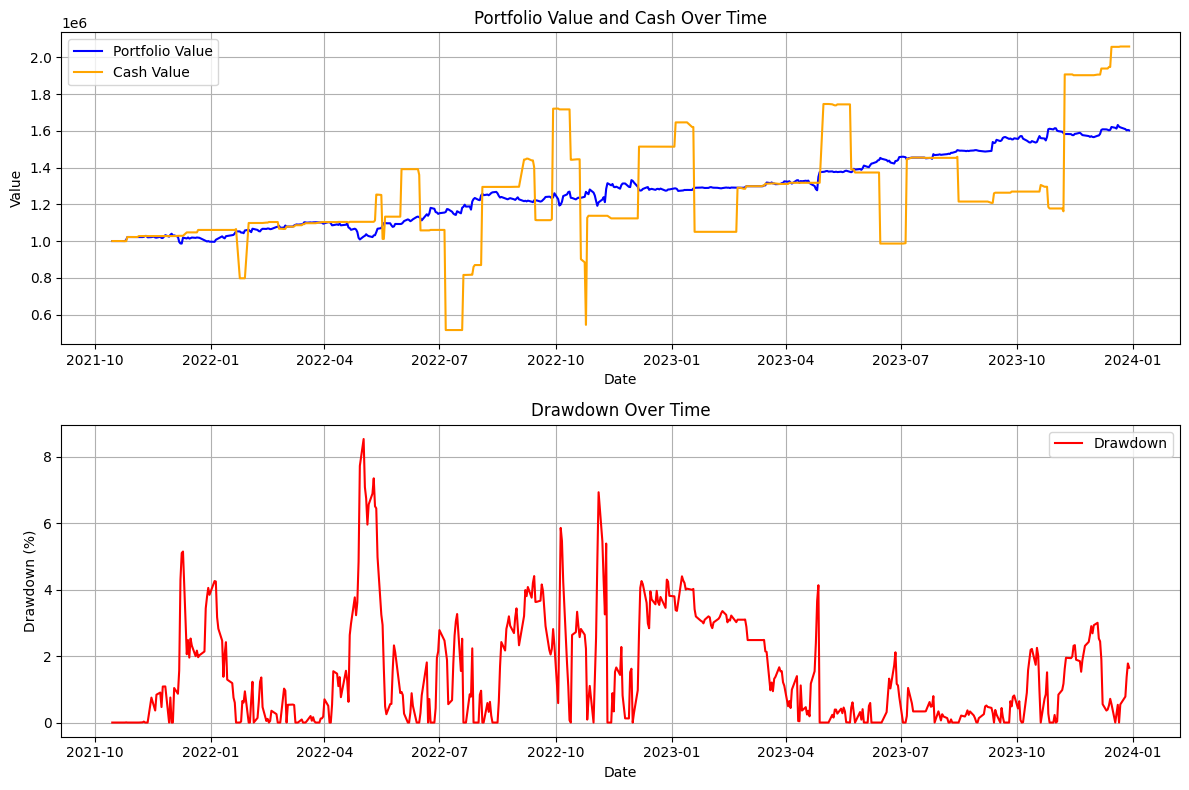

In [15]:
#%%

# Run LSTM Backtest
lstm_model = LSTMModel(return_matrix_testing_60_window, num_pairs=len(coint_pair))
lstm_model.train_model()
dynamic_weights_lstm = lstm_model.get_dynamic_weights()
run_backtest(
    data_dict=data_dict,
    used_tickers=used_tickers,
    coint_pair=coint_pair,
    best_z_scores_list=best_z_scores_list,
    hedge_ratios=hedge_ratios,
    dynamic_weights=dynamic_weights_lstm
)

In [ ]:
# Run Buy and Hold Dow Jones Index Backtest

class BuyAndHold(bt.Strategy):
    def __init__(self):
        self.dataclose = self.datas[0].close  
        self.portfolio_values = []  
        self.cash_values = []  
        self.dates = []  
        self.drawdowns = []

    def next(self):
        if self.position.size == 0:
            self.buy(size=int(self.broker.get_cash() / self.dataclose[0]))  


        self.portfolio_values.append(self.broker.get_value())
        self.cash_values.append(self.broker.get_cash())
        self.dates.append(self.datas[0].datetime.date(0))
        drawdown = self.analyzers.drawdown.get_analysis()['drawdown']
        self.drawdowns.append(drawdown)

def run_buy_and_hold_backtest(index_data):
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(1000000) 
    cerebro.broker.setcommission(commission=0.0001) 
    
    cerebro.adddata(index_data)
    cerebro.addstrategy(BuyAndHold)

    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio', timeframe=bt.TimeFrame.Days, annualize=True)
    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addobserver(bt.observers.DrawDown)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    results = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    sharpe_ratio = results[0].analyzers.sharpe_ratio.get_analysis()
    print(f"Sharpe Ratio: {sharpe_ratio['sharperatio']:.2f}")
    
    annual_return = results[0].analyzers.annual_return.get_analysis()
    total_return = 1
    for year, ret in annual_return.items():
        total_return *= (1 + ret)
    num_years = len(annual_return) - 1
    cagr = (total_return) ** (1 / num_years) - 1
    print(f"Compound Annual Growth Rate (CAGR): {cagr * 100:.2f}%")

    strategy = results[0]
    dates = strategy.dates
    portfolio_values = np.array(strategy.portfolio_values)
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    var_95 = np.percentile(returns, 5) 
    var_99 = np.percentile(returns, 1)  
    print(f"VaR 95%: {var_95 * 100:.2f}%")
    print(f"VaR 99%: {var_99 * 100:.2f}%")
    daily_volatility = np.std(returns)
    annualized_volatility = daily_volatility * np.sqrt(252) 
    print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")

    cash_values = strategy.cash_values
    drawdown_values = strategy.drawdowns

    strategy = results[0]
    dates = strategy.dates
    portfolio_values = strategy.portfolio_values
    cash_values = strategy.cash_values
    drawdown_values = strategy.drawdowns

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(dates, portfolio_values, label='Portfolio Value', color='blue')
    plt.plot(dates, cash_values, label='Cash Value', color='orange')
    plt.title('Portfolio Value and Cash Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(dates, drawdown_values, label='Drawdown', color='red')
    plt.title('Drawdown Over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


[*********************100%***********************]  1 of 1 completed


Starting Portfolio Value: 1000000.00
Final Portfolio Value: 1066097.79
Sharpe Ratio: 0.20
Compound Annual Growth Rate (CAGR): 3.25%
VaR 95%: -1.60%
VaR 99%: -2.75%
Annualized Volatility: 15.72%


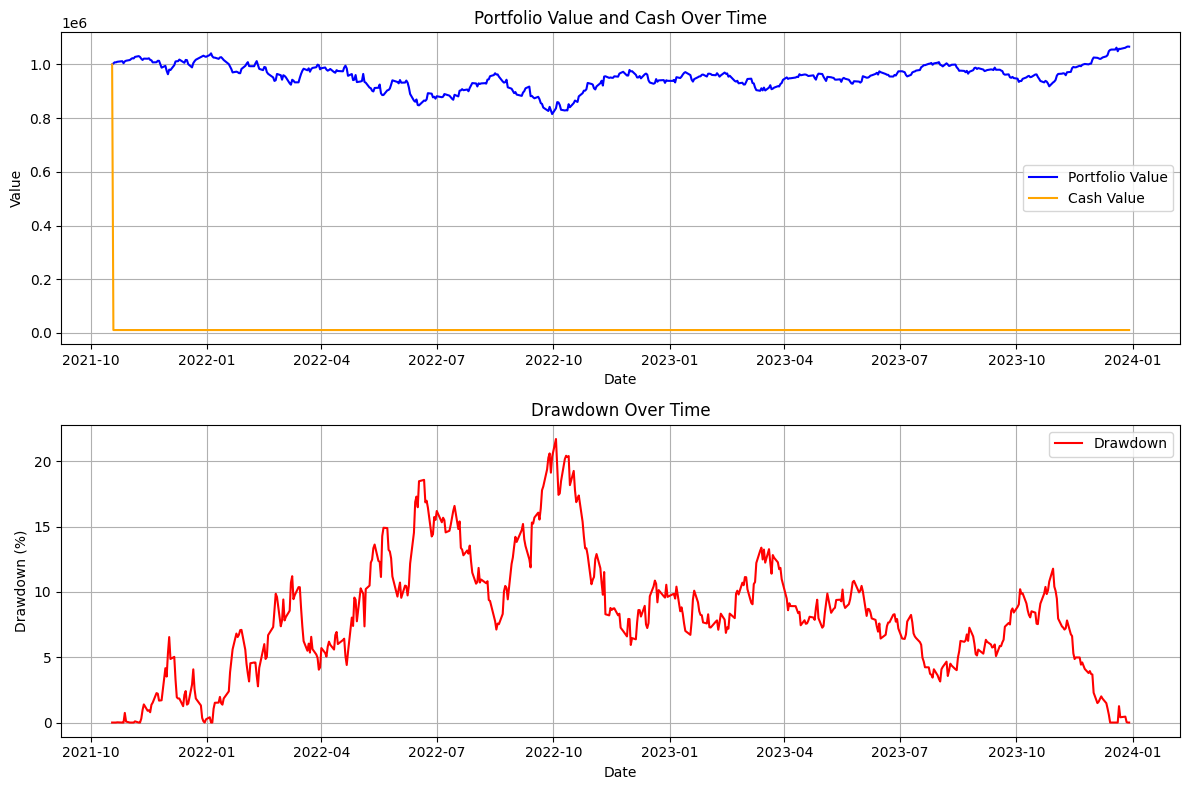

In [19]:
DJI_df = yf.download('^DJI', start='2021-10-18', end='2023-12-31')
DJI_data = bt.feeds.PandasData(dataname=DJI_df)
run_buy_and_hold_backtest(DJI_data)

[*********************100%***********************]  1 of 1 completed


Starting Portfolio Value: 1000000.00
Final Portfolio Value: 1051923.58
Sharpe Ratio: 0.16
Compound Annual Growth Rate (CAGR): 2.56%
VaR 95%: -1.93%
VaR 99%: -3.34%
Annualized Volatility: 19.06%


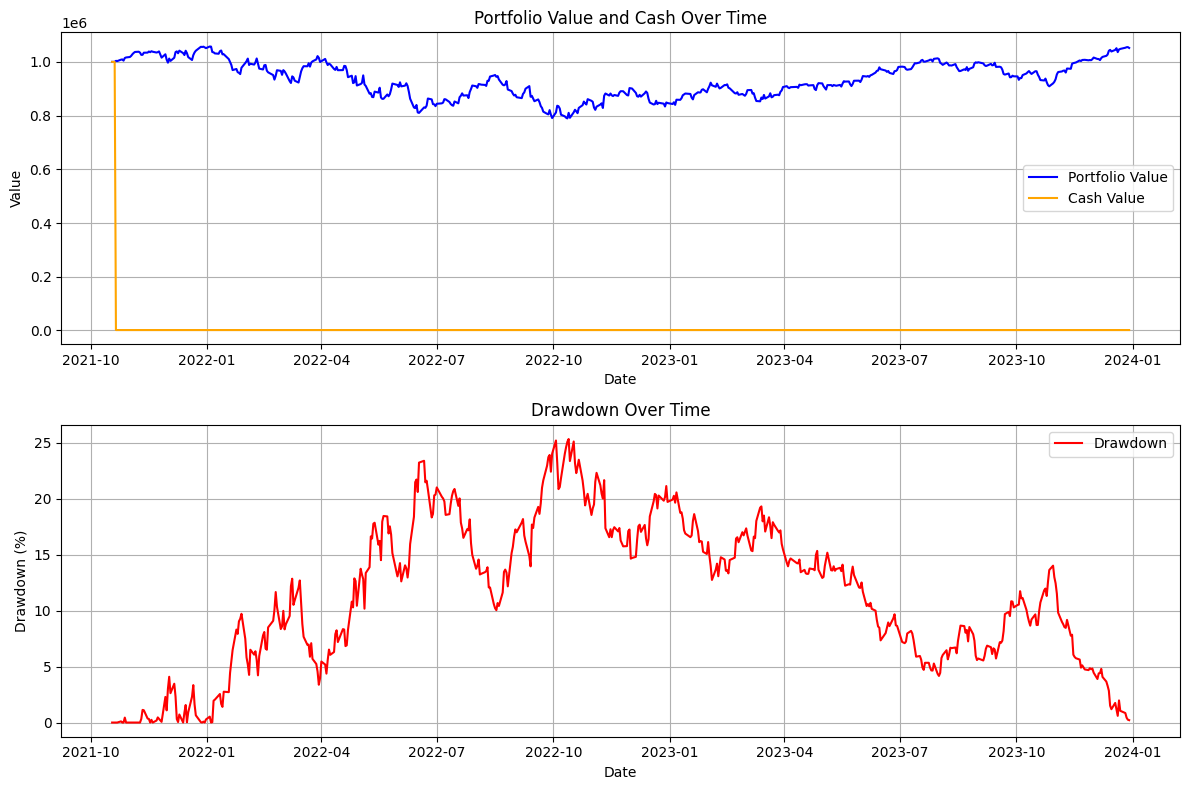

In [20]:
SPY_df = yf.download('SPY', start='2021-10-18', end='2023-12-31')
SPY_data = bt.feeds.PandasData(dataname=SPY_df)
run_buy_and_hold_backtest(SPY_data)

[*********************100%***********************]  1 of 1 completed


Starting Portfolio Value: 1000000.00
Final Portfolio Value: 995823.02
Sharpe Ratio: 0.08
Compound Annual Growth Rate (CAGR): -0.21%
VaR 95%: -2.51%
VaR 99%: -4.10%
Annualized Volatility: 25.05%


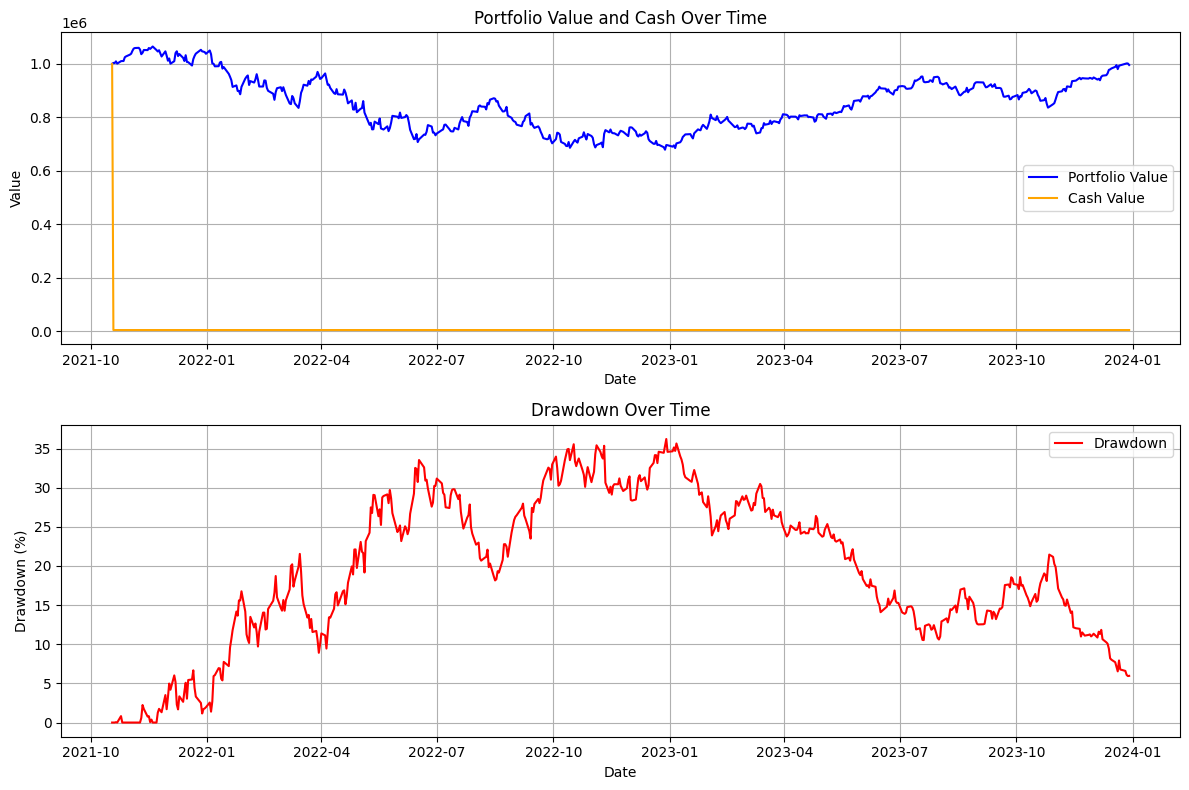

In [21]:
IXIC_df = yf.download('^IXIC', start='2021-10-18', end='2023-12-31')
IXIC_data = bt.feeds.PandasData(dataname=IXIC_df)
run_buy_and_hold_backtest(IXIC_data)